In [1]:
# Standard libraries
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.cross_validation import train_test_split

# Models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# For visualizing the decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Other libraries
import itertools

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# Load in data
data = pd.read_pickle('data_cleaned.pkl')

In [5]:
# Look at data
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,harmful,cleaned,...,model_text_tri,model_text_bi_tri,stem_model_text_bi,stem_model_text_tri,stem_model_text_bi_tri,cleaned_model_text,stem_model_text,num_words,target_label,num_label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,"[explanation, edits, username, hardcore, metal...",...,explanation edits username hardcore metallica ...,explanation edits username hardcore metallica ...,explan why the edit made under my usernam hard...,explan why the edit made under my usernam hard...,explan why the edit made under my usernam hard...,explanation edits username hardcore metallica ...,explan why the edit made under my usernam hard...,25,[clean],[0]
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,"[daww, matches, background, colour, seemingly,...",...,daww matches background colour seemingly stuck...,daww matches background colour seemingly stuck...,d'aww! he match thi background colour i'm seem...,d'aww! he match thi background colour i'm seem...,d'aww! he match thi background colour i'm seem...,daww matches background colour seemingly stuck...,d'aww! he match thi background colour i'm seem...,13,[clean],[0]
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,"[hey, man, trying, edit, war, guy, constantly,...",...,hey man trying edit war guy constantly removin...,hey man trying edit war guy constantly removin...,"hei man, i'm realli not try to edit war. it' j...","hei man, i'm realli not try to edit war. it' j...","hei man, i'm realli not try to edit war. it' j...",hey man trying edit war guy constantly removin...,"hei man, i'm realli not try to edit war. it' j...",19,[clean],[0]
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,"[real, suggestions, improvement, wondered, sec...",...,real suggestions improvement wondered section ...,real suggestions improvement wondered section ...,""" more i can't make ani real suggest on improv...",""" more i can't make ani real suggest on improv...",""" more i can't make ani real suggest on improv...",real suggestions improvement wondered section ...,""" more i can't make ani real suggest on improv...",38,[clean],[0]
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,"[sir, hero, chance, remember, page]",...,sir hero chance remember page sir_hero_chance ...,sir hero chance remember page sir_hero hero_ch...,"you, sir, ar my hero. ani chanc you rememb wha...","you, sir, ar my hero. ani chanc you rememb wha...","you, sir, ar my hero. ani chanc you rememb wha...",sir hero chance remember page,"you, sir, ar my hero. ani chanc you rememb wha...",5,[clean],[0]


In [6]:
# Look at nulls
data.isnull().sum()

id                        0
comment_text              0
toxic                     0
severe_toxic              0
obscene                   0
threat                    0
insult                    0
identity_hate             0
harmful                   0
cleaned                   0
stemmed                   0
model_text                0
model_text_bi             0
model_text_tri            0
model_text_bi_tri         0
stem_model_text_bi        0
stem_model_text_tri       0
stem_model_text_bi_tri    0
cleaned_model_text        0
stem_model_text           0
num_words                 0
target_label              0
num_label                 0
dtype: int64

In [7]:
# View shape of data
data.shape

(159571, 23)

## Class imbalance: undersample majority class non-toxic

In [8]:
# View class distribution for toxic and non-toxic comments
data.harmful.value_counts()

0    143346
1     16225
Name: harmful, dtype: int64

In [9]:
# Separate data into harmful comments and non-harmful comments
clean_data = data[data.harmful == 0]
harmful_data = data[data.harmful == 1]

In [10]:
print(clean_data.harmful.value_counts())
print(harmful_data.harmful.value_counts())

0    143346
Name: harmful, dtype: int64
1    16225
Name: harmful, dtype: int64


In [11]:
maj_class = clean_data.sample(frac=0.113)

In [12]:
len(maj_class)

16198

In [13]:
data_us = pd.concat([maj_class, harmful_data], axis=0)

In [14]:
data_us.harmful.value_counts()

1    16225
0    16198
Name: harmful, dtype: int64

## Split data into train, test, validate

In [15]:
# Choose X, y
X = data_us.iloc[:,18]
y = data_us.iloc[:,8]

In [16]:
# Split data into train, validate
X_1, X_validate, y_1, y_validate = train_test_split(X, y, test_size=0.3, random_state=1)

# Split train into train, test
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.3, random_state=1)

In [17]:
# Create list of model and accuracy dicts
list_of_perform = []

# List to keep track of models
models = []

# List to keep track of y_scores
y_scores = []

## TF-IDF

In [18]:
# Instantiate TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

In [19]:
# Fit / transform vectorizer
X_train = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
X_test = tfidf_vectorizer.transform(X_test.values.astype('U'))

X_validate = tfidf_vectorizer.transform(X_validate.values.astype('U'))

## 1 - Logistic Regression

### 1 - A) Logistic Regression Baseline Model

In [20]:
# Instantiate model
lr_baseline = LogisticRegression(random_state=1)

# Calculate accuracy of train
lr_base_acc = cross_val_score(lr_baseline, X_train, y_train).mean()
lr_base_std = cross_val_score(lr_baseline, X_train, y_train).std()
print('Accuracy of log reg baseline (TRAIN): {} +/- {}'.format(round(lr_base_acc, 2), round(lr_base_std, 2)))

# Fit model
lr_baseline.fit(X_train, y_train)

# Get predictions and probabilities
lr_base_preds = lr_baseline.predict(X_test)
lr_base_y_score = lr_baseline.predict_proba(X_test)

# Calculate accuracy of test
lr_base_acc_test = round(accuracy_score(y_test, lr_base_preds), 2)
print(f'Accuracy of log reg baseline (TEST): {lr_base_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, lr_base_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# Add model and accuracy dict to list
list_of_perform.append(dict([
    ('Model', 'LogReg Base'),
    ('Train Accuracy', round(lr_base_acc, 2)),
    ('Test Accuracy', lr_base_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('LogReg Base')

# Add y_score to list
y_scores.append(lr_base_y_score)

Accuracy of log reg baseline (TRAIN): 0.88 +/- 0.0
Accuracy of log reg baseline (TEST): 0.88

Precision : 0.8871879731212882
Recall    : 0.8850512881662924
F-score   : 0.8845842616953643


### 1 - B) Random Search Logistic Regression

In [21]:
# Define the parameter values that should be searched
tol_range = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 100, 1000]
C_range = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 100, 1000, 10000]
fit_intercept_range = [True, False]

print(tol_range,
      C_range,
      fit_intercept_range)

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 100, 1000] [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 100, 1000, 10000] [True, False]


In [22]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_rand = dict(tol=tol_range,
                  C=C_range,
                  fit_intercept=fit_intercept_range,)
print(param_rand)

{'tol': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 100, 1000], 'C': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 100, 1000, 10000], 'fit_intercept': [True, False]}


In [23]:
# Choose number of searches
n_iter_search = 60

# Instantiate the model
lr_random_search = RandomizedSearchCV(lr_baseline, param_distributions=param_rand, n_iter=n_iter_search)

# Fit the model
lr_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=60, n_jobs=1,
          param_distributions={'tol': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 100, 1000], 'C': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 100, 1000, 10000], 'fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [24]:
# View best parameter
print('Best parameters found:')
print()
print(lr_random_search.best_params_)

Best parameters found:

{'tol': 0.001, 'fit_intercept': True, 'C': 100}


In [25]:
# View the complete results
#lr_grid.grid_scores_

### 1 - C) Logistic Regression Optimized w/ Random Search

In [26]:
# Instantiate model
lr_opt = LogisticRegression(tol=0.001, C=100, fit_intercept=True, random_state=1)

# Calculate accuracy of train
lr_opt_acc = cross_val_score(lr_opt, X_train, y_train).mean()
lr_opt_std = cross_val_score(lr_opt, X_train, y_train).std()
print('Accuracy of log reg optimized (TRAIN): {} +/- {}'.format(round(lr_opt_acc, 2), round(lr_opt_std, 2)))

# Fit model
lr_opt.fit(X_train, y_train)

# Get predictions and probabilities
lr_opt_preds = lr_opt.predict(X_test)
lr_opt_y_score = lr_opt.predict_proba(X_test)

# Calculate accuracy of test
lr_opt_acc_test = round(accuracy_score(y_test, lr_opt_preds), 2)
print(f'Accuracy of log reg optimized (TEST): {lr_opt_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, lr_opt_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# Add model and accuracy dict to list
list_of_perform.append(dict([
    ('Model', 'LogReg Opt GS'),
    ('Train Accuracy', round(lr_opt_acc, 2)),
    ('Test Accuracy', lr_opt_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('LogReg Opt RS')

# Add y_score to list
y_scores.append(lr_opt_y_score)

Accuracy of log reg optimized (TRAIN): 0.88 +/- 0.0
Accuracy of log reg optimized (TEST): 0.88

Precision : 0.8838502581657435
Recall    : 0.8832868931047002
F-score   : 0.8830680960701645


## 2 - KNN

### 2 - A) KNN Baseline Model

In [27]:
# Instantiate model
neigh_base = KNeighborsClassifier()

# Calculate accuracy of train
neigh_base_acc = cross_val_score(neigh_base, X_train, y_train).mean()
neigh_base_std = cross_val_score(neigh_base, X_train, y_train).std()
print('Accuracy of KNN baseline (TRAIN): {} +/- {}'.format(round(neigh_base_acc, 2), round(neigh_base_std, 2)))

# Fit model
neigh_base.fit(X_train, y_train)

# Get predictions and probabilities
neigh_base_preds = neigh_base.predict(X_test)
neigh_base_y_score = neigh_base.predict_proba(X_test)

# Calculate accuracy of test
neigh_base_acc_test = round(accuracy_score(y_test, neigh_base_preds), 2)
print(f'Accuracy of KNN baseline (TEST): {neigh_base_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, neigh_base_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# Add model and accuracy dict to list
list_of_perform.append(dict([
    ('Model', 'KNN Base'),
    ('Train Accuracy', round(neigh_base_acc, 2)),
    ('Test Accuracy', neigh_base_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('KNN Base')

# Add y_score to list
y_scores.append(neigh_base_y_score)

Accuracy of KNN baseline (TRAIN): 0.61 +/- 0.11
Accuracy of KNN baseline (TEST): 0.55

Precision : 0.5581402831402831
Recall    : 0.5471636372233258
F-score   : 0.5257158132939996


### 2 - B) Grid Search KNN

In [28]:
# Define parameters that should be searched
n_neighbors_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
weights_range = ['uniform', 'distance']

print(n_neighbors_range,
      weights_range)

[2, 3, 4, 5, 6, 7, 8, 9, 10] ['uniform', 'distance']


In [29]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=n_neighbors_range,
                  weights=weights_range)

print(param_grid)

{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance']}


In [30]:
# Instantiate the model
knn_grid_search = GridSearchCV(neigh_base, param_grid)

# Fit the model
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
# View best parameters
print('Best parameters found:')
print()
print(knn_grid_search.best_params_)

Best parameters found:

{'n_neighbors': 10, 'weights': 'uniform'}


### 2 - C) KNN Optimized w/ Grid Search

In [32]:
# Instantiate the model
knn_opt = KNeighborsClassifier(n_neighbors=10, weights='uniform')

# Calculate accuracy of train
knn_opt_acc = cross_val_score(knn_opt, X_train, y_train).mean()
knn_opt_std = cross_val_score(knn_opt, X_train, y_train).std()
print('Accuracy of KNN optimized (TRAIN): {} +/- {}'.format(round(knn_opt_acc, 2), round(knn_opt_std, 2)))

# Fit model
knn_opt.fit(X_train, y_train)

# Get predictions and probabilities
knn_opt_preds = knn_opt.predict(X_test)
knn_opt_y_score = knn_opt.predict_proba(X_test)

# Calculate accuracy of test
knn_opt_acc_test = round(accuracy_score(y_test, knn_opt_preds), 2)
print(f'Accuracy of KNN optimized (TEST): {knn_opt_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, knn_opt_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# Add model and accuracy dict to list
list_of_perform.append(dict([
    ('Model', 'KNN Opt GS'),
    ('Train Accuracy', round(knn_opt_acc, 2)),
    ('Test Accuracy', knn_opt_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('KNN Opt GS')

# Add y_score to list
y_scores.append(knn_opt_y_score)

Accuracy of KNN optimized (TRAIN): 0.77 +/- 0.04
Accuracy of KNN optimized (TEST): 0.78

Precision : 0.7791193429609768
Recall    : 0.777492043008823
F-score   : 0.7773902894312572


## 3 - Decision Tree

### 3 - A) Decision Tree Baseline Model

In [33]:
# Instantiate the model
dt_base = DecisionTreeClassifier(random_state=1)

# Calculate accuracy of train
dt_base_acc = cross_val_score(dt_base, X_train, y_train).mean()
dt_base_std = cross_val_score(dt_base, X_train, y_train).std()
print('Accuracy of Decision Tree baseline (TRAIN): {} +/- {}'.format(round(dt_base_acc, 2), round(dt_base_std, 2)))

# Fit model
dt_base.fit(X_train, y_train)

# Get predictions and probabilities
dt_base_preds = dt_base.predict(X_test)
dt_base_y_score = dt_base.predict_proba(X_test)

# Calculate accuracy of test
dt_base_acc = round(accuracy_score(y_test, dt_base_preds), 2)
print(f'Accuracy of Decision Tree baseline (TEST): {dt_base_acc}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, dt_base_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# Add model and accuracy dict to list
list_of_perform.append(dict([
    ('Model', 'DecTree Base'),
    ('Train Accuracy', round(dt_base_acc, 2)),
    ('Test Accuracy', dt_base_acc),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('DecTree Base')

# Add y_score to list
y_scores.append(dt_base_y_score)

Accuracy of Decision Tree baseline (TRAIN): 0.82 +/- 0.01
Accuracy of Decision Tree baseline (TEST): 0.82

Precision : 0.822306789238407
Recall    : 0.8213516997002883
F-score   : 0.8213799495096978


## 4 - Random Forest Classifier

### 4 - A) Random Forest Baseline Model

In [34]:
# Instantiate the model
rf_base = RandomForestClassifier(random_state=1)

# Calculate accuracy of train
rf_base_acc = cross_val_score(rf_base, X_train, y_train).mean()
rf_base_std = cross_val_score(rf_base, X_train, y_train).std()
print('Accuracy of Random Forest baseline (TRAIN): {} +/- {}'.format(round(rf_base_acc, 2), round(rf_base_std, 2)))

# Fit model
rf_base.fit(X_train, y_train)

# Get predictions and probabilities
rf_base_preds = rf_base.predict(X_test)
rf_base_y_score = rf_base.predict_proba(X_test)

# Calculate accuracy of test
rf_base_acc_test = round(accuracy_score(y_test, rf_base_preds), 2)
print(f'Accuracy of Random Forest baseline (TEST): {rf_base_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, rf_base_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# Add model and accuracy dict to list
list_of_perform.append(dict([
    ('Model', 'RandFor Base'),
    ('Train Accuracy', round(rf_base_acc, 2)),
    ('Test Accuracy', rf_base_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('RandFor Base')

# Add y_score to list
y_scores.append(rf_base_y_score)

Accuracy of Random Forest baseline (TRAIN): 0.83 +/- 0.01
Accuracy of Random Forest baseline (TEST): 0.83

Precision : 0.8400528140161773
Recall    : 0.8312172211998681
F-score   : 0.8295203145774102


# Part 3: Performance

### Accuracy

In [35]:
model_perf = pd.DataFrame(data=list_of_perform)
model_perf = model_perf[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
#model_perf.drop_duplicates(inplace=True)
model_perf

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,LogReg Base,0.88,0.88,0.89,0.89,0.88
1,LogReg Opt GS,0.88,0.88,0.88,0.88,0.88
2,KNN Base,0.61,0.55,0.56,0.55,0.53
3,KNN Opt GS,0.77,0.78,0.78,0.78,0.78
4,DecTree Base,0.82,0.82,0.82,0.82,0.82
5,RandFor Base,0.83,0.83,0.84,0.83,0.83


### Plot ROC Curve

In [36]:
models
# y_scores

['LogReg Base',
 'LogReg Opt RS',
 'KNN Base',
 'KNN Opt GS',
 'DecTree Base',
 'RandFor Base']

In [41]:
def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2
    
    # Logistic Regression Baseline
    fpr, tpr, thresholds = roc_curve(y_test, lr_base_y_score[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test, lr_base_y_score[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR Baseline, auc=%.3f' % auc_lr)
        
    # Logistic Regression w/ Random Search
    fpr, tpr, thresholds = roc_curve(y_test, lr_opt_y_score[:,1], pos_label=1)
    auc_lr_opt = roc_auc_score(y_test, lr_opt_y_score[:,1])
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='LR Optimized, auc=%.3f' % auc_lr_opt)
        
    # KNN Baseline
    fpr, tpr, thresholds = roc_curve(y_test, neigh_base_y_score[:,1], pos_label=1)
    auc_knn = roc_auc_score(y_test, neigh_base_y_score[:,1])
    plt.plot(fpr, tpr, color='y',
             lw=lw, label='KNN Baseline, auc=%.3f' % auc_knn)
    
    # KNN w/ Grid Search
    fpr, tpr, thresholds = roc_curve(y_test, knn_opt_y_score[:,1], pos_label=1)
    auc_knn_opt = roc_auc_score(y_test, knn_opt_y_score[:,1])
    plt.plot(fpr, tpr, color='chartreuse',
             lw=lw, label='KNN Optimized, auc=%.3f' % auc_knn_opt)
    
    # Decision Tree Baseline
    fpr, tpr, thresholds = roc_curve(y_test, dt_base_y_score[:,1], pos_label=1)
    auc_dt_base = roc_auc_score(y_test, dt_base_y_score[:,1])
    plt.plot(fpr, tpr, color='m',
             lw=lw, label='Decision Tree Baseline, auc=%.3f' % auc_dt_base)
    
    # Random Forest Baseline
    fpr, tpr, thresholds = roc_curve(y_test, rf_base_y_score[:,1], pos_label=1)
    auc_rf = roc_auc_score(y_test, rf_base_y_score[:,1])
    plt.plot(fpr, tpr, color='#08e8de',
             lw=lw, label='Random Forest Baseline, auc=%.3f' % auc_rf)
    
    # Formatting
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

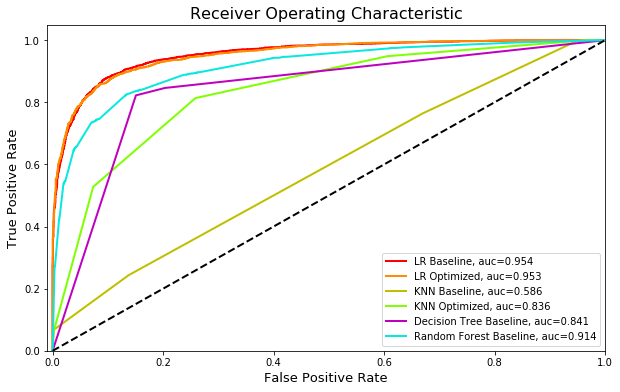

In [42]:
plot_roc_curves()